# 1. About Project
Cookie Cats is a popular mobile puzzle game developed by Tactile Entertainment. 
In this project, I will analyze the results of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention

## 1.2 Data Description
The data is from 90.189 players that installed the while the A/B test was running. 
Variables:
- *userid:* player id
- *version:* whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).
- *sum_gamerounds:* the number of game rounds played by the player during the first week after installation
- *retention_1:* did the player come back and play 1 day after installing?
- *retention_7:* did the player come back and play 7 days after installing?

when a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.

## 1.3 Import Packages

In [1]:
import itertools 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.stats.api as sms
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, \
    pearsonr, spearmanr, kendalltau, f_oneway, kruskal, kstest, ks_2samp
from statsmodels.stats.proportion import proportions_ztest

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.width', 500)

# 2.1 DataUnderstanding

In [2]:
df = pd.read_csv("cookie_cats.csv")

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(90189, 5)
##################### Types #####################
userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object
##################### Head #####################
   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True
##################### Tail #####################
        userid  version  sum_gamerounds  retention_1  retention_7
90184  9999441  gate_40              97         True        False
90185  9999479  gate_40              30        False        False
90186  9999710  gate_30              28         True        False
90187  9999768  gate_4

## 2.2 Analyzing Player Behavior

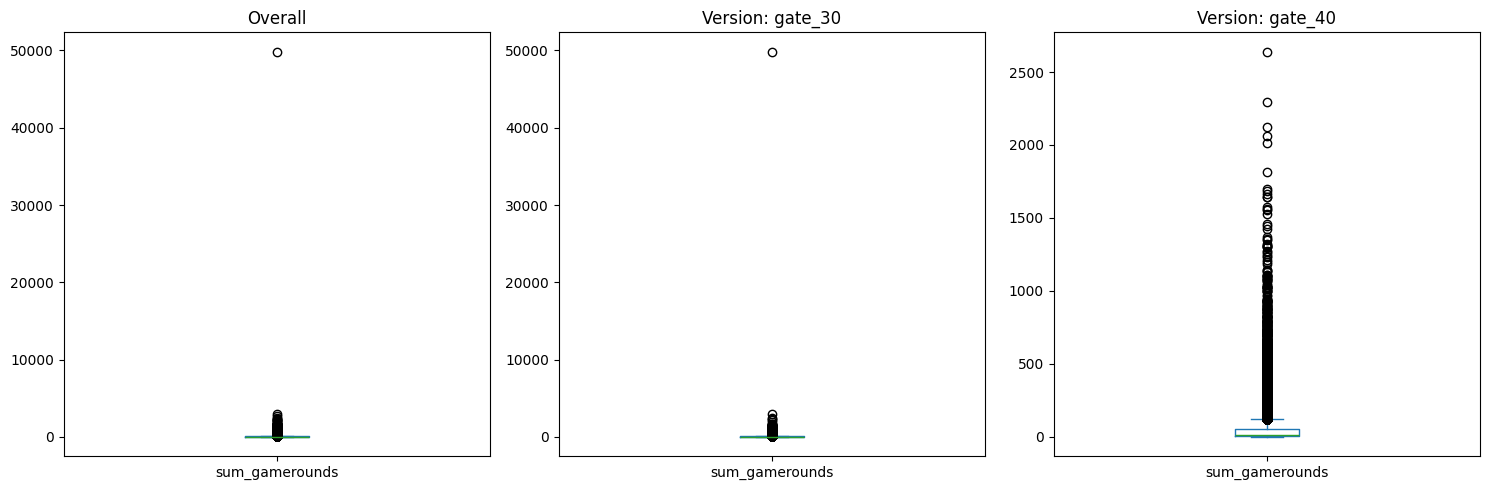

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure and subplots

# Plotting the first boxplot
df['sum_gamerounds'].plot.box(ax=axes[0])
axes[0].set_title('Overall')

# Plotting the second boxplot
df.loc[df["version"] == "gate_30", 'sum_gamerounds'].plot.box(ax=axes[1])
axes[1].set_title('Version: gate_30')

# Plotting the third boxplot
df.loc[df["version"] == "gate_40", 'sum_gamerounds'].plot.box(ax=axes[2])
axes[2].set_title('Version: gate_40')

plt.tight_layout()
plt.show()

### Explore the distribution of game rounds

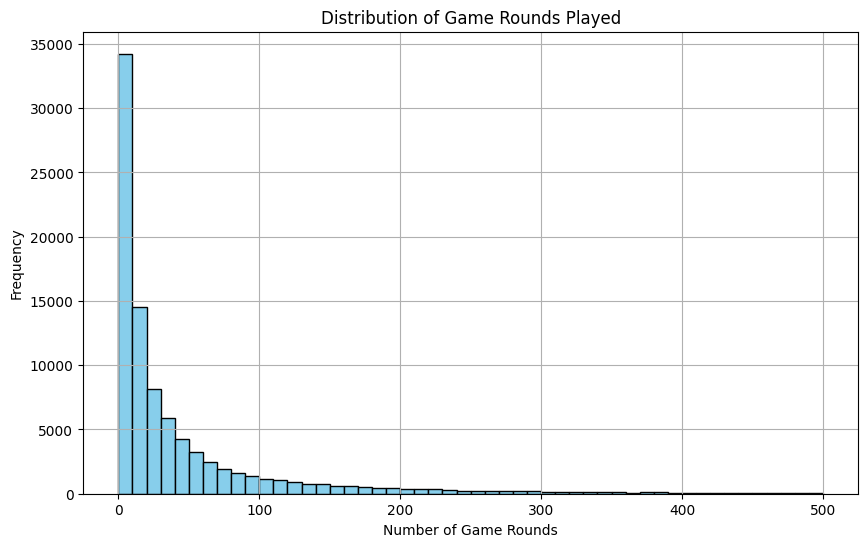

In [4]:
plt.figure(figsize=(10, 6))
plt.hist(df['sum_gamerounds'], bins=50, range=(0, 500), color='skyblue', edgecolor='black')
plt.title('Distribution of Game Rounds Played')
plt.xlabel('Number of Game Rounds')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

* On the left side of the graph, tall bars indicate that a large number of players played fewer than 50 game rounds in their first week. 
* Moving to the right, the height of the bars decreases, showing a sharp decreases in the frequency of players as the number of game rounds increases. 
* The distribution has a long tail, indicating that a small number of players played more than 200 or 300 game rounds.

### Compare retention rates between different versions

In [5]:
retention_rates = df.groupby('version').agg(retention_1_rate=pd.NamedAgg(column='retention_1', aggfunc='mean'),
                                            retention_7_rate=pd.NamedAgg(column='retention_7', aggfunc='mean')
                                         ).reset_index()
retention_rates

,version,retention_1_rate,retention_7_rate
0,gate_30,0.44819,0.19020
1,gate_40,0.44228,0.18200


-  Retention rates for the gate_30 version are slightly higher than those for the gate_40 version on both day 1 and day 7.

### Analyze the relationship between game rounds played and retention

C:\Users\hbz\AppData\Local\Temp\ipykernel_20420\644437115.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='retention_1', y='sum_gamerounds', data=df, ax=axes[0], palette='Set1')
C:\Users\hbz\AppData\Local\Temp\ipykernel_20420\644437115.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='retention_7', y='sum_gamerounds', data=df, ax=axes[1], palette='Set1')


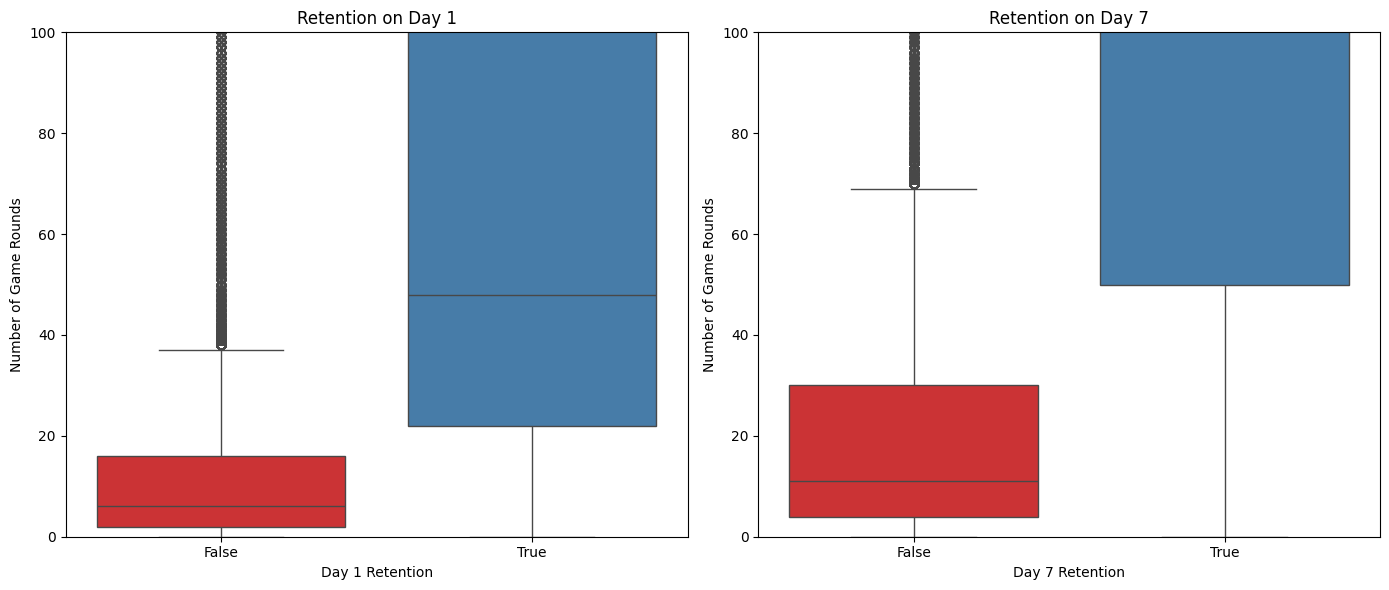

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Box plot for retention on day 1
sns.boxplot(x='retention_1', y='sum_gamerounds', data=df, ax=axes[0], palette='Set1')
axes[0].set_title('Retention on Day 1')
axes[0].set_xlabel('Day 1 Retention')
axes[0].set_ylabel('Number of Game Rounds')
axes[0].set_ylim(0, 100)

# Box plot for retention on day 7
sns.boxplot(x='retention_7', y='sum_gamerounds', data=df, ax=axes[1], palette='Set1')
axes[1].set_title('Retention on Day 7')
axes[1].set_xlabel('Day 7 Retention')
axes[1].set_ylabel('Number of Game Rounds')
axes[1].set_ylim(0, 100)

plt.tight_layout()
plt.show()

* Day 1 Retention: Players who retained on day 1(True) tent to have played more game rounds than those who did not retain (False). This is indicated by the higher median and larger spread of the box for terained players.

* Day 7 Retention: Similarly, players who retained on day 7(True) tend to have played more game rounds than those who did not retain(False). The difference in medians and the spread of the boxes is more pronounced for day 7 retention compared to day 1 retention.

- Sum of the number of rounds player played based on versions:

In [7]:
df.groupby('version').agg({"sum_gamerounds": "count"})

,sum_gamerounds
version,
gate_30,44700
gate_40,45489


- Mean of the number of rounds player played based on versions

In [8]:
df.groupby("version").agg({"sum_gamerounds" : "mean"})

,sum_gamerounds
version,
gate_30,52.45626
gate_40,51.29878


# 3 Extreme Values

In [9]:
df_gate_40 = df[df["version"] == "gate_40"]
df_gate_30 = df[df["version"] == "gate_30"]

def outlier_thresholds(dataframe, variable):
    quartile3 = df[variable].quantile(0.01)
    quartile1 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile1 - quartile3
    upper_limit = quartile1 + interquantile_range * 1.5
    lower_limit = quartile3 - interquantile_range * 1.5
    return upper_limit, lower_limit

def replace_with_threshold(dataframe, variable):
    upper_limit, lower_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] > upper_limit), variable] = round(upper_limit)
    dataframe.loc[(dataframe[variable] < lower_limit), variable] = round(lower_limit)
    
replace_with_threshold(df_gate_40, "sum_gamerounds")
replace_with_threshold(df_gate_30, "sum_gamerounds")

df_new = pd.concat([df_gate_40, df_gate_30], ignore_index=True)   

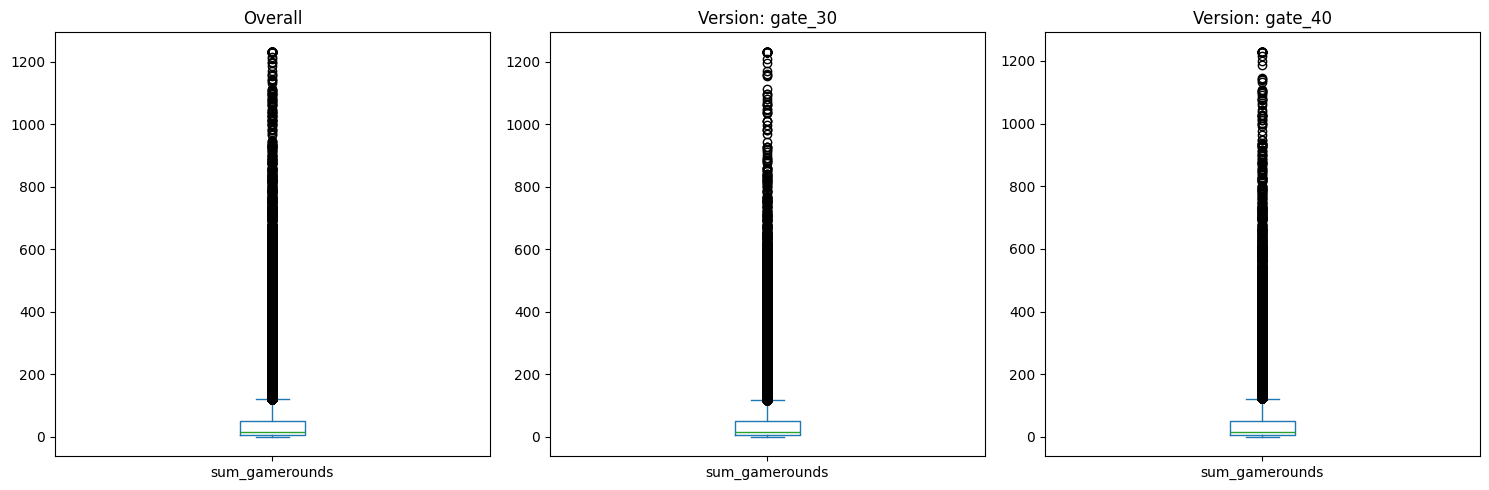

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure and subplots

# Plotting the first boxplot
df_new['sum_gamerounds'].plot.box(ax=axes[0])
axes[0].set_title('Overall')

# Plotting the second boxplot
df_new.loc[df_new["version"] == "gate_30", 'sum_gamerounds'].plot.box(ax=axes[1])
axes[1].set_title('Version: gate_30')

# Plotting the third boxplot
df_new.loc[df_new["version"] == "gate_40", 'sum_gamerounds'].plot.box(ax=axes[2])
axes[2].set_title('Version: gate_40')

plt.tight_layout()
plt.show()

# 4.1 A/B Test

In [11]:
def ab_test(dataframe, group, control, test, target):
    # Check for normality
    test_stat, pvalue_control = shapiro(dataframe.loc[dataframe[group] == control, target])
    test_stat, pvalue_test = shapiro(dataframe.loc[dataframe[group] == test, target])

    # If p-value > 0.05, distribution is considered normal
    normal_control = pvalue_control > 0.05
    normal_test = pvalue_test > 0.05

    if normal_control and normal_test:
        # Both groups have normal distribution, check for homogeneity of variances
        test_stat, pvalue_levene = levene(dataframe.loc[dataframe[group] == control, target],
                                  dataframe.loc[dataframe[group] == test, target])
        if pvalue_levene > 0.05:
            # Variances are equal
            test_stat, pvalue = ttest_ind(dataframe.loc[dataframe[group] == control, target],
                                  dataframe.loc[dataframe[group] == test, target], equal_var=True)
        else:
            # Variances are not equal
            test_stat, pvalue = ttest_ind(dataframe.loc[dataframe[group] == control, target],
                                  dataframe.loc[dataframe[group] == test, target], equal_var=False)
            print("Variances are not equal, used Welch's t-test")
    else:
        # Non-parametric test (Mann-Whitney U test)
        test_stat, pvalue = mannwhitneyu(dataframe.loc[dataframe[group] == control, target],
                                 dataframe.loc[dataframe[group] == test, target])

    # Interpret the results
    if pvalue > 0.05:
        print(f"There is no statistically significant difference in {target} between {control} and {test}")
    else:
        print(f"There is a statistically significant difference in {target} between {control} and {test}")
    print(f'Test Statistic = {test_stat: .4f}, p-value = {pvalue: .4f}')


ab_test(df_new, "version", "gate_30", "gate_40", "sum_gamerounds")

There is no statistically significant difference in sum_gamerounds between gate_30 and gate_40
Test Statistic =  1024331740.0000, p-value =  0.0502


c:\Users\hbz\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 44700.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\hbz\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 45489.
  res = hypotest_fun_out(*samples, **kwds)


There is no statistically significant difference between the total number of rounds played for version of players (gate_30 and gate_40). Lets look at if there is a statistically significant diffrence between retention day 1 and retention day 7 for players versions.

In [12]:
ab_test(df_new, "version", "gate_30", "gate_40", "retention_1")

There is no statistically significant difference in retention_1 between gate_30 and gate_40
Test Statistic =  1022682813.0000, p-value =  0.0744


In [13]:
ab_test(df_new, "version", "gate_30", "gate_40", "retention_7")

There is a statistically significant difference in retention_7 between gate_30 and gate_40
Test Statistic =  1025017239.0000, p-value =  0.0016


# 4.2 Bootstrapping (for looking the retentions)

Within the video gaming industry, a commonly utilized metric for assessing the enjoyment and engagement level of a game is 1-day retention. A higher 1-day retention rate facilitates the retention of players and contributes to the establishment of a robust player base.

In [14]:
df_new.groupby("version").agg({"retention_1":"mean","retention_7":"mean"})

,retention_1,retention_7
version,,
gate_30,0.44819,0.19020
gate_40,0.44228,0.18200


Bootstrapping is a technique in which you repeatedly sample from your data with replacement. This technique helps estimate the uncertainty or variability of a statistic without relying on assumptions about the data's distribution. It is useful for generating confidence intervals and assessing uncertainty in statistical analyses.

Using bootstrap analysis, the probability that 1-day and 7-day retention is greater when the gate is at level 30 will be examined.

In [15]:
def bootstrap_means(data, column, num_samples=1000):
    means = []
    for i in range(num_samples):
        bootstrap_sample = np.random.choice(data[column], len(data), replace=True)
        means.append(np.mean(bootstrap_sample))
    return means

# Perform bootstrapping for retention_1 and retention_7 for gate_30
bootstrapped_means_1_gate_30 = bootstrap_means(df_gate_30, 'retention_1')
bootstrapped_means_7_gate_30 = bootstrap_means(df_gate_30, 'retention_7')

# Perform bootstrapping for retention_1 and retention_7 for gate_40
bootstrapped_means_1_gate_40 = bootstrap_means(df_gate_40, 'retention_1')
bootstrapped_means_7_gate_40 = bootstrap_means(df_gate_40, 'retention_7')

# Calculate the probabilities
prob_1day_gate_30_greater = np.mean(np.array(bootstrapped_means_1_gate_30) > np.array(bootstrapped_means_1_gate_40))
prob_7day_gate_30_greater = np.mean(np.array(bootstrapped_means_7_gate_30) > np.array(bootstrapped_means_7_gate_40))

# Print the probabilities
print("Probability that 1-day retention is greater when the gate is at level 30:", prob_1day_gate_30_greater)
print("Probability that 7-day retention is greater when the gate is at level 30:", prob_7day_gate_30_greater)

Probability that 1-day retention is greater when the gate is at level 30: 0.965
Probability that 7-day retention is greater when the gate is at level 30: 1.0


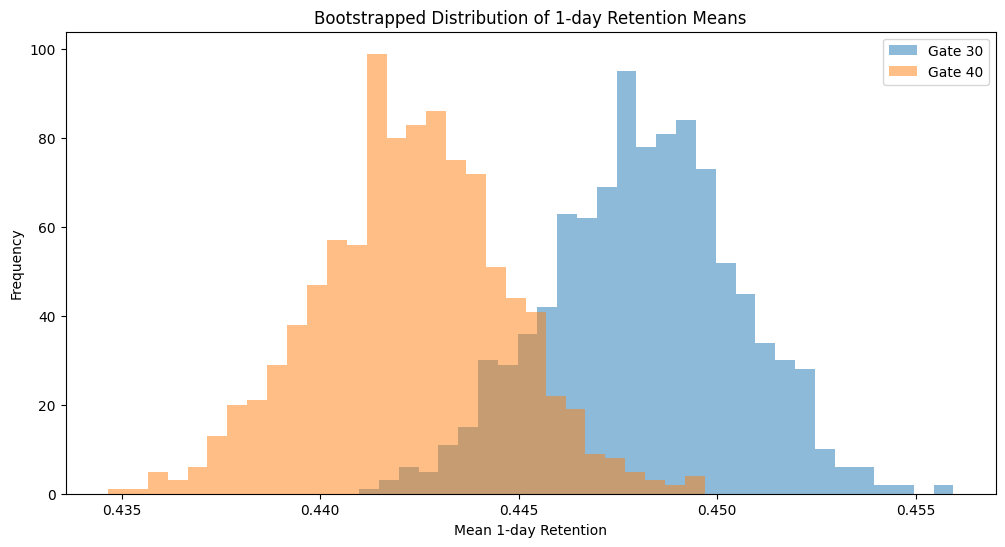

In [16]:
# Plot the bootstrapped distributions
plt.figure(figsize=(12, 6))
plt.hist(bootstrapped_means_1_gate_30, bins=30, alpha=0.5, label='Gate 30')
plt.hist(bootstrapped_means_1_gate_40, bins=30, alpha=0.5, label='Gate 40')
plt.title('Bootstrapped Distribution of 1-day Retention Means')
plt.xlabel('Mean 1-day Retention')
plt.ylabel('Frequency')
plt.legend()
plt.show()

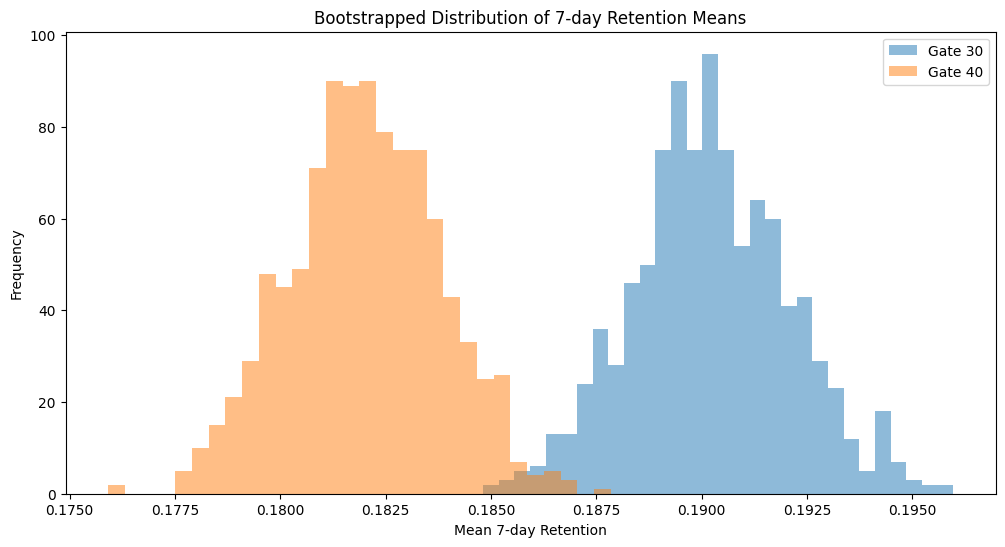

In [17]:
plt.figure(figsize=(12, 6))
plt.hist(bootstrapped_means_7_gate_30, bins=30, alpha=0.5, label='Gate 30')
plt.hist(bootstrapped_means_7_gate_40, bins=30, alpha=0.5, label='Gate 40')
plt.title('Bootstrapped Distribution of 7-day Retention Means')
plt.xlabel('Mean 7-day Retention')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 6. Conclusion

**Bootstrap Analysis Results:**
<p> Gate_30 has a higher 1-day retention rate than gate_40 with a probability of 96.85%. Similarly, for the 7-day retention rate, gate_30 outperforms gate_40 with a probability of 99.85%. The results indicate that gate_30 is more effective than gate_40 in retaining users in the game for a longer period of time.
</p>

**A/B Test Results:**
<p> The A/B test results indicate that there is no statistically significant difference between M1(gate_30) and M2(gate_40) for the 1-day retention rate(p-value = 0.0744). This suggests that there is no significant difference between the two versions in terms of shor-term retention. However, for the 7-day retention rate, the A/B test shows a statistically significant difference between M1(gate_30) and M2(gate_40)(p-value = 0.0016). The gate_30 version has a higher long-term retention rate than the gate_40 version.
</p>

**Comments:**
<p> *Short Term(1-Day) Retention Rate:* Although the A/B test shows no statistically significant difference between short-term retention rates, bootstrap analysis suggests that gate_30 is slightly better. However the p-value of the A/B test (0.0744) is quite close to the generally accepted significance threshold of 0.05, so this difference may have practical significance. 
</p>
</p> Long-Term(7-Day) Retention Base: Both analysis indicate that gate_30 has a higher long-term retention rate than gate_40. The bootstrap analysis demonstrates a significant difference, which is confirmed by A/B testing.

To increase long-term user retention, it is recommended to use gate_30 instead of gate_40. For short-term retention, there is no significant difference between the two versions, but gate_30 may have a slight advantage. When making these decisions, it is important to consider factors such as user experience, gameplay, and other business metrics.